In [3]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np


In [4]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)


In [5]:
query = """


SELECT
        t.date_nk,
        (count(DISTINCT case when user_sk != 'unknown' then session_long else NULL end)) dauli,
         count(DISTINCT session_long) dau
            FROM ods.fact_user_hydra_browsing_activity t
                WHERE
                    channel_sk IN ('mobile_app|android','mobile_app|ios','web|mobile_web|html5','web|desktop_web','web|mobile_web')
                    --AND is_panamera=TRUE
                    AND country_sk='olx|asia|id'
                    AND date_nk > '2019-01-01' -- Dia de la migracion fue 2019-08-19/20
        GROUP BY 1
        ORDER BY 1

"""


query2 = """


SELECT
        t.date_nk,
        (count(DISTINCT case when user_sk != 'unknown' then session_long else NULL end)) dauli,
         count(DISTINCT session_long) dau
            FROM ods.fact_user_hydra_browsing_activity t
                WHERE
                    channel_sk IN ('mobile_app|android','mobile_app|ios','web|mobile_web|html5','web|desktop_web','web|mobile_web')
                    AND is_panamera=TRUE
                    AND country_sk='olx|asia|id'
                    AND date_nk = '2019-08-20' -- Dia de la migracion fue 2019-08-19/20
        GROUP BY 1
        ORDER BY 1

"""

In [6]:
df = pd.read_sql_query(query.replace('%', '%%'), engine)
df2 = pd.read_sql_query(query2.replace('%', '%%'), engine)

In [39]:
df.to_csv('indonesia_channel')

In [ ]:
correr la query2 unicamente una vez que termine de correr

In [16]:
df.tail(20)

,date_nk,dauli,dau,classic
211,2019-08-01,838100,1212732,1
212,2019-08-02,825321,1182870,1
213,2019-08-03,791262,1101058,1
214,2019-08-04,684838,944684,1
215,2019-08-05,771570,1115140,1
216,2019-08-06,799501,1156600,1
217,2019-08-07,819376,1182473,1
218,2019-08-08,790990,1144326,1
219,2019-08-09,772228,1110257,1
220,2019-08-10,762591,1058461,1


In [15]:
dfpan = df2.tail(1)

In [18]:
df['classic'] = 1
dfpan['panamera'] = 1
dfs = pd.merge(df , dfpan , how='left' , on=['date_nk']).fillna(0)
dfs.tail()

/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date_nk,dauli_x,dau_x,classic,dauli_y,dau_y,panamera
226,2019-08-16,743354,1064996,1,0.0,0.0,0.0
227,2019-08-17,708353,976993,1,0.0,0.0,0.0
228,2019-08-18,738258,1014388,1,0.0,0.0,0.0
229,2019-08-19,806655,1167906,1,0.0,0.0,0.0
230,2019-08-20,847279,1682311,1,697373.0,1476174.0,1.0


In [23]:
dfs['dauli'] = np.where(dfs['panamera']==0 , dfs['dauli_x'] , dfs['dauli_y'])
dfs['dau'] = np.where(dfs['panamera']==0 , dfs['dau_x'] , dfs['dau_y'])
dfs['dauli_dau'] = (dfs['dauli'] / dfs['dau'])*100
dfgr = dfs[['date_nk' , 'dauli_dau']]
dfgr = dfgr.set_index('date_nk')

Text(0.5, 0, 'Date')

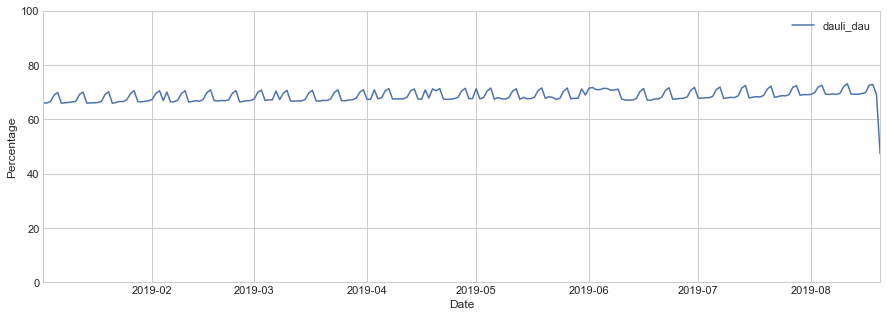

In [28]:
fig , ax1 = plt.subplots(1,1,figsize=(15,5))
dfgr.plot(ax=ax1)
ax1.set_ylim((0,100))
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Date')

In [30]:
dfs.to_csv('indonesia')